In [3]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt

dicom_dir = '/home/mhb0917/의료영상처리/202255646/task6_blind'
dicom_files = sorted([f for f in os.listdir(dicom_dir) if f.endswith('.dcm')])

# DICOM 메타데이터 수집
datasets = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in dicom_files]

# pixel spacing: [dy, dx]
pixel_spacing = list(map(float, datasets[0].PixelSpacing))
dy, dx = pixel_spacing[0] / 10, pixel_spacing[1] / 10  # cm 단위

# z 방향 spacing 계산 (ImagePositionPatient 사용)
z_positions = [float(ds.ImagePositionPatient[2]) for ds in datasets]
z_sorted = sorted(z_positions)
dz = abs(z_sorted[1] - z_sorted[0]) / 10  # cm 단위

# 영상 크기 및 3D 볼륨 생성
rows, cols = datasets[0].Rows, datasets[0].Columns
volume = np.zeros((len(datasets), rows, cols), dtype=np.int16)

for i, ds in enumerate(datasets):
    volume[i, :, :] = ds.pixel_array

print(f"3D Volume shape: {volume.shape}")
print(f"Voxel spacing (cm): dx={dx:.3f}, dy={dy:.3f}, dz={dz:.3f}")


3D Volume shape: (125, 512, 512)
Voxel spacing (cm): dx=0.083, dy=0.083, dz=0.250


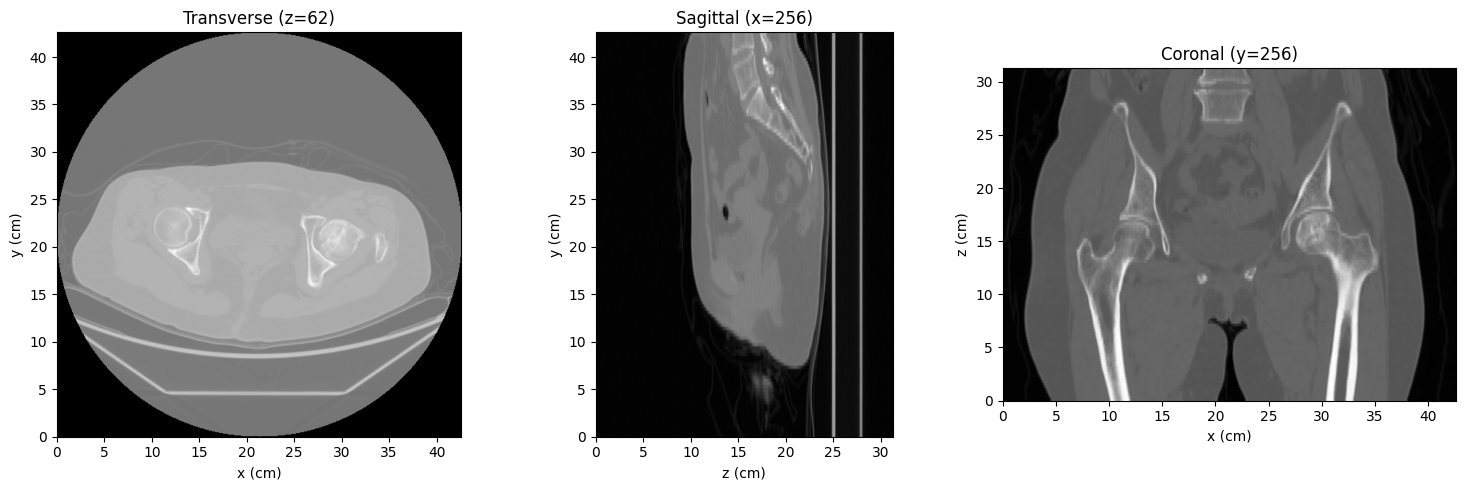

In [4]:
# 시각화를 위한 슬라이스 선택
slice_transverse = volume.shape[0] // 2   # z 가운데
slice_sagittal = volume.shape[2] // 2     # x 가운데
slice_coronal = volume.shape[1] // 2      # y 가운데

# 축 단위 설정
z_cm = np.arange(volume.shape[0]) * dz
y_cm = np.arange(volume.shape[1]) * dy
x_cm = np.arange(volume.shape[2]) * dx

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1️⃣ Transverse (횡단면: xy 평면)
axes[0].imshow(volume[slice_transverse, :, :], cmap='gray',
               extent=[0, dx*volume.shape[2], 0, dy*volume.shape[1]])
axes[0].set_title(f'Transverse (z={slice_transverse})')
axes[0].set_xlabel('x (cm)')
axes[0].set_ylabel('y (cm)')

# 2️⃣ Sagittal (시상면: zy 평면)
axes[1].imshow(volume[:, :, slice_sagittal], cmap='gray',
               extent=[0, dz*volume.shape[0], 0, dy*volume.shape[1]])
axes[1].set_title(f'Sagittal (x={slice_sagittal})')
axes[1].set_xlabel('z (cm)')
axes[1].set_ylabel('y (cm)')

# 3️⃣ Coronal (관상면: zx 평면)
axes[2].imshow(volume[:, slice_coronal, :], cmap='gray',
               extent=[0, dx*volume.shape[2], 0, dz*volume.shape[0]])
axes[2].set_title(f'Coronal (y={slice_coronal})')
axes[2].set_xlabel('x (cm)')
axes[2].set_ylabel('z (cm)')

plt.tight_layout()
plt.show()


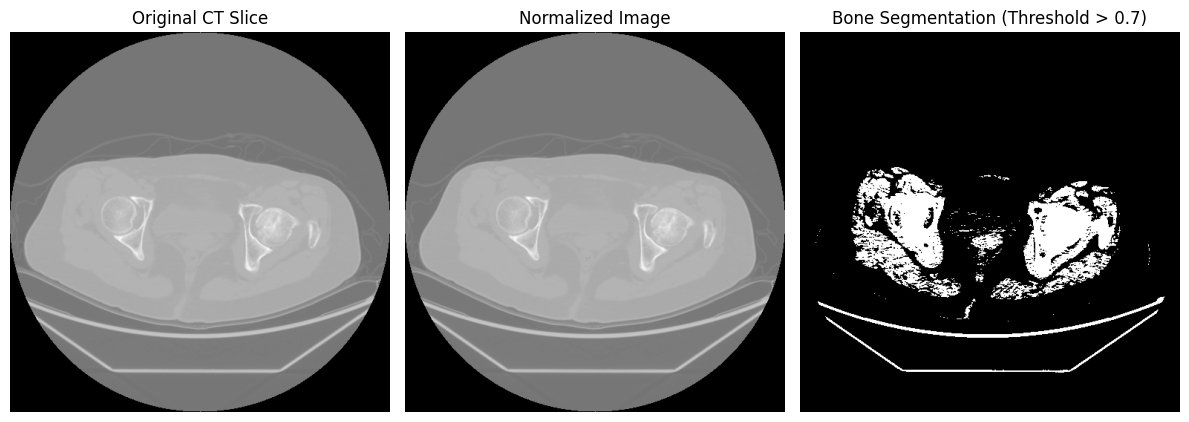

In [5]:
# 중간 transverse 슬라이스 하나 선택
slice_index = volume.shape[0] // 2
img = volume[slice_index]

# 정규화
img_norm = (img - img.min()) / (img.max() - img.min())

# Thresholding: 뼈는 높은 강도 영역이므로 상위 30%만 선택
threshold = 0.7
bone_mask = img_norm > threshold

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.title('Original CT Slice')
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Normalized Image')
plt.imshow(img_norm, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Bone Segmentation (Threshold > 0.7)')
plt.imshow(bone_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


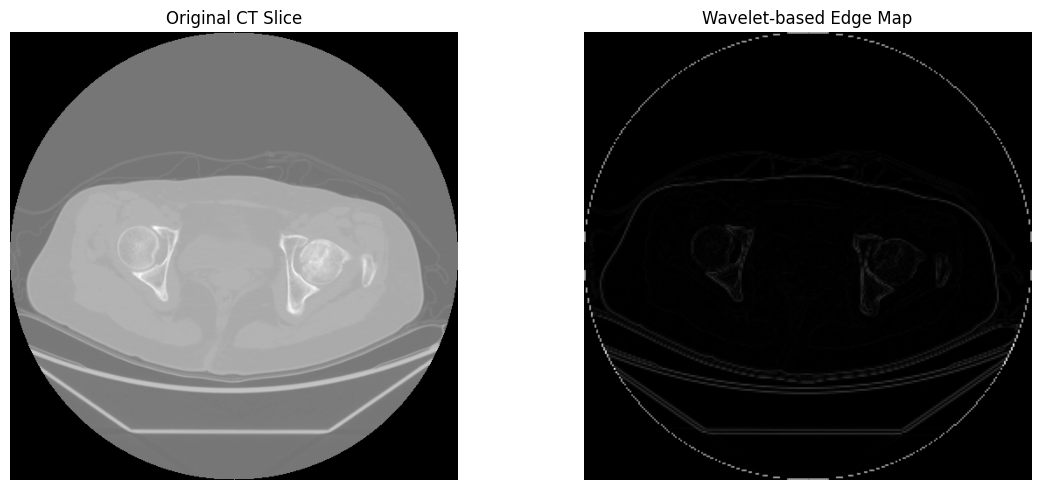

In [6]:
import pywt
import matplotlib.pyplot as plt

# 사용할 슬라이스 선택 (이전과 동일)
slice_index = volume.shape[0] // 2
img = volume[slice_index].astype(np.float32)

# 정규화 (wavelet은 float 기준)
img_norm = (img - np.min(img)) / (np.max(img) - np.min(img))

# Wavelet 2D 변환 (Haar 또는 db1 사용)
coeffs2 = pywt.dwt2(img_norm, 'haar')  # 또는 'db2', 'db4' 사용 가능
cA, (cH, cV, cD) = coeffs2  # approximation, horizontal, vertical, diagonal

# 엣지 크기 조합 (단순 합 또는 sqrt)
edges = np.sqrt(cH**2 + cV**2 + cD**2)

# 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Original CT Slice')
plt.imshow(img_norm, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Wavelet-based Edge Map')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
